<a href="https://colab.research.google.com/github/jobellet/vlPFC_Visual_Geometry/blob/main/LSF_information_and_object_identification_gain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----------------------------------------------------------------------------
# LSF information and object identification gain
-----------------------------------------------------------------------------
- Analysis of the position and category information contained in the early vlPFC response and the LSF component of images.

- Testing the hypothesis that this early information can serve as prior for better object identification
-----------------------------------------------------------------------------
## Private key
For the notebook to download the data from the Figshare repository prior to acceptance of the manuscript you need to insert the private link token mentioned in the "Code availability" section of the manuscript.

In [ ]:
private_link = input('Enter the private link token:')

# First, download data and import toolboxes

In [3]:
import os, re, pickle, warnings, time
from pathlib import Path
from itertools import combinations
import sys
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from scipy.stats import binomtest
from statsmodels.stats.multitest import multipletests
from pathlib import PurePath
from scipy.stats import gaussian_kde
import jax.numpy as jnp
from jax import jit

# Determine the path to the repository based on the environment
IN_COLAB = False
IN_KAGGLE = False # Assuming not in Kaggle for now
try:
    if 'google.colab' in str(get_ipython()):
        IN_COLAB = True
except NameError:
    pass

if IN_COLAB:
    path_to_repo = '/content/vlPFC_Visual_Geometry'
elif IN_KAGGLE:
    path_to_repo = '/kaggle/working/vlPFC_Visual_Geometry'
else:
    # Assume local environment where the .py file is in the root of the repo
    path_to_repo = '.'

# Only clone if not already present
if not os.path.exists(path_to_repo):
    os.system("git clone https://github.com/jobellet/vlPFC_Visual_Geometry.git " + path_to_repo)

sys.path.append(path_to_repo)
sys.path.append(os.path.join(path_to_repo, 'utils'))

from extract_and_download_data import download_files, unzip


FIG_DIR = Path("Figures") # Convert to Path object
os.makedirs(FIG_DIR, exist_ok=True)
CACHE_DIR = Path(".cache");   CACHE_DIR.mkdir(exist_ok=True) # From Category decoding

# Define the directory where files are downloaded
DOWNLOAD_DIR = Path("downloads") # Convert to Path object
os.makedirs(DOWNLOAD_DIR, exist_ok=True)


# -------------------------------------------------------------------
# Download required data files once (using the new method)
files_to_download = [
    "Spike_count_even_sessions.npy",
    "Spike_count_odd_sessions.npy",
    "hvm_public_extended_meta.csv",
    "deepNetFeatures.zip",
    "background_variations_images.zip",
    "high_variation_stimuli.zip",
]
# Pass the correct path to file_code_mapping.csv to download_files
download_success = download_files(path_to_repo, files_to_download, private_link=private_link)

meta_downloaded_path = DOWNLOAD_DIR / "hvm_public_extended_meta.csv" # Use Path object
dnn_zip_downloaded_path = DOWNLOAD_DIR / "deepNetFeatures.zip" # Use Path object
even_downloaded_path = DOWNLOAD_DIR / "Spike_count_even_sessions.npy" # Use Path object
odd_downloaded_path = DOWNLOAD_DIR / "Spike_count_odd_sessions.npy" # Use Path object


meta_downloaded = meta_downloaded_path.exists()
dnn_zip_downloaded = dnn_zip_downloaded_path.exists()
even_downloaded_check = even_downloaded_path.exists()
odd_downloaded_check = odd_downloaded_path.exists()


if not (meta_downloaded and dnn_zip_downloaded):
    print("Failed to download necessary files. Exiting.")
    # exit() # Do not exit, just skip the parts that require these files

if dnn_zip_downloaded:
    # Update unzip to use the downloaded zip path and specify the extraction directory
    unzip(dnn_zip_downloaded_path, "deepNetFeatures")


Successfully downloaded downloads/hvm_public_extended_meta.csv.
Successfully downloaded downloads/background_variations_images.zip.
Successfully downloaded downloads/high_variation_stimuli.zip.
Successfully downloaded downloads/deepNetFeatures.zip.
Successfully downloaded downloads/Spike_count_even_sessions.npy.
Successfully downloaded downloads/Spike_count_odd_sessions.npy.


# Category-abstract position decoding

Decoding neural data …
Decoding low‑pass DNN features …
Done [51.1 s]
Saved → mean_pos_error_per_trial.npy


/tmp/ipython-input-1919048502.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Source", y="MAE", data=plot_df,


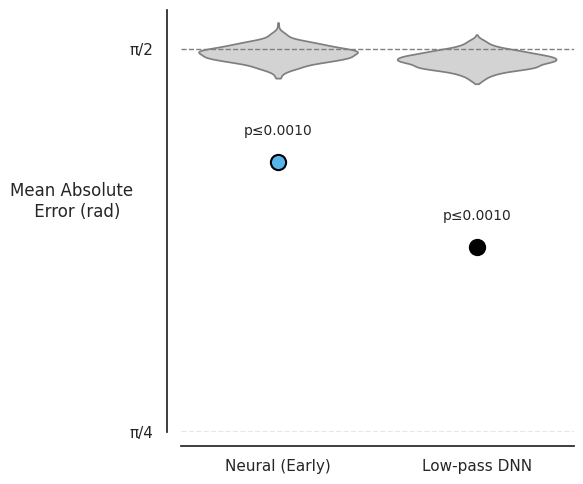

Figure saved → Figures/objpos_decoding_neural_early_and_dnn_LSF.png
                 Figures/objpos_decoding_neural_early_and_dnn_LSF.svg
                 Figures/objpos_decoding_neural_early_and_dnn_LSF.pdf


In [4]:
def load_and_align(pkl_path, meta_df):
    with open(pkl_path, "rb") as fh:
        d = pickle.load(fh)
    X = d["penultimate"]
    if X.ndim > 2:
        X = X.reshape(X.shape[0], -1)
    names = [Path(n).stem for n in d["image_names"]]
    idx = [names.index(b) for b in meta_df["base"]]
    return X[idx].astype(np.float64)

def predict_angles(net, pkl_path, meta_df, y_target, categories):
    # `net` kept in signature for compatibility with your Parallel(...) call
    X = load_and_align(pkl_path, meta_df)
    pred_t = np.zeros_like(y_target, dtype=np.float64)
    for cat in categories:
        tr = meta_df["category_name"] != cat
        te = ~tr
        pca = PCA(n_components=50, random_state=42)
        Xtr = pca.fit_transform(X[tr])
        Xte = pca.transform(X[te])
        reg = LinearRegression().fit(Xtr, y_target[tr])
        pred_t[te] = reg.predict(Xte)
    ang = np.arctan2(pred_t[:, 1], pred_t[:, 0])
    return ang

meta = pd.read_csv(meta_downloaded_path)
meta["base"] = meta["filename"].str.replace(r"\.\w+$", "", regex=True)
valid_idx = np.arange(640, len(meta))
meta = meta.iloc[valid_idx].reset_index(drop=True)

# centroid → polar angle (y, x)
pos = np.vstack((meta["centroid_y"].values, meta["centroid_x"].values)).T
pos = (pos - 128) / 256 * 8
true_angle = np.arctan2(pos[:, 1], pos[:, 0])
y_target = np.column_stack((np.cos(true_angle), np.sin(true_angle)))

categories = meta["category_name"].unique()
cat_labels = meta["category_name"].values  # for within‑category permutations

# Small helper for circular diffs
def circ_diff(a, b):
    return np.arctan2(np.sin(a - b), np.cos(a - b))

# Precompute indices for each category (used by both neural & DNN perms)
_cat_to_idx = {c: np.flatnonzero(cat_labels == c) for c in categories}

rate_even = None
rate_odd = None

if even_downloaded_check and odd_downloaded_check: # Check for downloaded files
    print("Decoding neural data …")
    # Update load paths
    rate_even = np.load(even_downloaded_path, allow_pickle=True)
    rate_odd  = np.load(odd_downloaded_path,  allow_pickle=True)

    # Assign to even and odd for use in Distance to Template
    even = rate_even
    odd = rate_odd

    time_course = np.arange(0, 200, 10)
    rate = ((rate_even + rate_odd)/2)
    # keep only the 2 560 stimuli aligned with `meta`
    rate = rate[valid_idx]

    time_range_early = slice(5, 9)   # 50–90 ms

    model = LinearRegression()
    angle_diff = {}
    for label, t_idx in {"Early": time_range_early}.items():
        feats = rate[:, :, t_idx].reshape(rate.shape[0], -1)
        pred_target = np.zeros_like(y_target)
        for cat in categories:
            tr = meta["category_name"] != cat
            te = ~tr
            pca = PCA(n_components=50, random_state=42)
            Xtr = pca.fit_transform(feats[tr])
            Xte = pca.transform(feats[te])
            reg = LinearRegression().fit(Xtr, y_target[tr])
            pred_target[te] = reg.predict(Xte)
        pred_ang = np.arctan2(pred_target[:, 1], pred_target[:, 0])
        angle_diff[label] = circ_diff(pred_ang, true_angle)

    # Mean absolute error + permutation test (CATEGORY‑ABSTRACT)
    N_PERM = 1000
    mae_neural = {lbl: np.abs(diff).mean() for lbl, diff in angle_diff.items()}
    mae_perm_neural = {lbl: np.empty(N_PERM) for lbl in angle_diff}

    for lbl in angle_diff:
        # recover predicted angle for that label
        pred_ang = angle_diff[lbl] + true_angle  # inverse of circ_diff operation
        for i in range(N_PERM):
            # shuffle true angles WITHIN each category
            shuffled = true_angle.copy()
            for c, idxs in _cat_to_idx.items():
                shuffled[idxs] = np.random.permutation(shuffled[idxs])
            diff_p = circ_diff(pred_ang, shuffled)
            mae_perm_neural[lbl][i] = np.abs(diff_p).mean()

    # DataFrame for violin
    neural_perm_df = pd.DataFrame({
        "MAE": mae_perm_neural["Early"],
        "Source": ["Neural (Early)"] * N_PERM # Changed TimePeriod to Source for consistency
    })
else:
    print("Skipping neural data decoding due to failed download.")
    mae_perm_neural = {"Early": np.array([])}
    mae_neural = {"Early": np.nan}
    neural_perm_df = pd.DataFrame({"MAE": [], "Source": []}) # Changed TimePeriod to Source


# -------------------------------------------------------------
# 2.  LOW‑PASS DNN DECODING (pooled across networks)
# -------------------------------------------------------------
if dnn_zip_downloaded:
    print("Decoding low‑pass DNN features …")
    feature_dir = Path("deepNetFeatures") # Directory where zip is extracted
    # Updated regex pattern to match the filenames after extraction
    pkl_re = re.compile(r"^(?P<net>.*?)_features_high_variation_lowpass\.pkl$")
    feat_files = [(m.group("net"), p) for p in feature_dir.glob("*.pkl")
                  if (m := pkl_re.match(p.name))]

    if not feat_files:
        print(f"Error: No low-pass DNN feature files found in {feature_dir}.")
        # Set variables to indicate missing data
        perm_mae_dnn = np.array([])
        mae_dnn = np.nan
        err_per_trial = np.array([])
    else:
        N_PCS = 50

        start = time.time()
        pred_angles_all = Parallel(n_jobs=-1, backend="loky", verbose=0)(
            delayed(predict_angles)(n, p, meta, y_target, categories) for n, p in feat_files)
        print(f"Done [{time.time()-start:.1f} s]")

        pred_angles_all = np.vstack(pred_angles_all)   # n_nets × n_trials
        # Average prediction: vector‑sum on the unit circle
        avg_cos = np.cos(pred_angles_all).mean(axis=0)
        avg_sin = np.sin(pred_angles_all).mean(axis=0)
        avg_pred_angle = np.arctan2(avg_sin, avg_cos)

        # Per‑trial absolute error
        err_per_trial = np.abs(circ_diff(avg_pred_angle, true_angle))
        np.save("mean_pos_error_per_trial.npy", err_per_trial)
        print("Saved → mean_pos_error_per_trial.npy")

        mae_dnn = err_per_trial.mean()

        # Permutation distribution for pooled predictor (CATEGORY‑ABSTRACT)
        perm_mae_dnn = np.empty(N_PERM)
        for i in range(N_PERM):
            shuffled = true_angle.copy()
            # shuffle within each category
            for c, idxs in _cat_to_idx.items():
                shuffled[idxs] = np.random.permutation(shuffled[idxs])
            diff_p = np.abs(circ_diff(avg_pred_angle, shuffled))
            perm_mae_dnn[i] = diff_p.mean()
else:
    print("Skipping DNN decoding due to failed download.")
    perm_mae_dnn = np.array([])
    mae_dnn = np.nan
    err_per_trial = np.array([]) # Set to empty to indicate missing data
# -------------------------------------------------------------
# 3) Plot – side-by-side violins + empirical dots + p‑values
# -------------------------------------------------------------
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def perm_pvalue(empirical, null_samples):
    """One-sided p-value: proportion of null MAEs <= empirical MAE (plus 1 correction)."""
    if null_samples is None or len(null_samples) == 0 or np.isnan(empirical):
        return np.nan
    return (np.sum(null_samples <= empirical) + 1) / (len(null_samples) + 1)

plot_dfs = []
if (neural_perm_df is not None) and (not neural_perm_df.empty):
    plot_dfs.append(neural_perm_df)
if isinstance(perm_mae_dnn, np.ndarray) and perm_mae_dnn.size > 0:
    plot_dfs.append(pd.DataFrame({"MAE": perm_mae_dnn, "Source": "Low-pass DNN"}))

if plot_dfs:
    plot_df = pd.concat(plot_dfs, ignore_index=True)

    # Compute permutation p-values
    p_neural = perm_pvalue(mae_neural.get("Early", np.nan), mae_perm_neural.get("Early", np.array([])))
    p_dnn    = perm_pvalue(mae_dnn, perm_mae_dnn)

    sns.set_theme(style="white")
    palette = {"Neural (Early)": (0.3372549 , 0.70588235, 0.91372549),   # same blue as in RSA
               "Low-pass DNN":  "black"}

    order = ["Neural (Early)", "Low-pass DNN"]
    # Only keep sources present
    order = [s for s in order if s in plot_df["Source"].unique()]

    fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)

    # Violin plots for permutation nulls
    sns.violinplot(x="Source", y="MAE", data=plot_df,
                   order=order, palette=["lightgray"]*len(order),
                   inner=None, ax=ax, cut=0)

    # Overlay empirical MAEs
    x_positions = {src: i for i, src in enumerate(order)}
    if "Neural (Early)" in order and not np.isnan(mae_neural.get("Early", np.nan)):
        ax.scatter(x_positions["Neural (Early)"], mae_neural["Early"],
                   color=palette["Neural (Early)"], edgecolors="black",
                   s=120, linewidths=1.5, zorder=10)
    if "Low-pass DNN" in order and not np.isnan(mae_dnn):
        ax.scatter(x_positions["Low-pass DNN"], mae_dnn,
                   color=palette["Low-pass DNN"], edgecolors="black",
                   s=120, linewidths=1.5, zorder=10)

    # Reference lines
    ax.axhline(y=np.pi/2, color='gray', linestyle='--', linewidth=1)
    ax.axhline(y=np.pi/4, color='gray', linestyle='--', linewidth=1)

    # Cosmetics
    ax.set_ylabel("Mean Absolute \n Error (rad)", rotation=0, labelpad=40)
    ax.set_xlabel("")
    ax.set_yticks([np.pi/4, np.pi/2])
    ax.set_yticklabels(['π/4', 'π/2'])
    ax.set_ylim(np.pi/4, 1.65)
    sns.despine(ax=ax, offset=10)

    # P-value annotations above dots
    def annotate_p(x, y, p):
        if np.isnan(p):
            return
        ax.text(x, y + 0.05, f"p≤{p:.4f}", ha="center", va="bottom", fontsize=10)

    if "Neural (Early)" in order and not np.isnan(mae_neural.get("Early", np.nan)):
        annotate_p(x_positions["Neural (Early)"], mae_neural["Early"], p_neural)
    if "Low-pass DNN" in order and not np.isnan(mae_dnn):
        annotate_p(x_positions["Low-pass DNN"], mae_dnn, p_dnn)

    # Save
    FIG_DIR.mkdir(exist_ok=True)
    out_png = FIG_DIR / "objpos_decoding_neural_early_and_dnn_LSF.png"
    out_svg = FIG_DIR / "objpos_decoding_neural_early_and_dnn_LSF.svg"
    out_pdf = FIG_DIR / "objpos_decoding_neural_early_and_dnn_LSF.pdf"
    fig.savefig(out_png, dpi=300)
    fig.savefig(out_svg)
    fig.savefig(out_pdf)
    plt.show()

    print(f"Figure saved → {out_png}\n                 {out_svg}\n                 {out_pdf}")
else:
    print("Skipping plot: no permutation data available.")


# Object-generalizing category information

Pairwise category decoding — Neural (50–90 ms)…
Pairwise category decoding — Low‑pass DNN …
   · decoding ConvNeXt_base_in22ft1k_features_high_variation_lowpass.pkl
   · decoding Inception_v3_features_high_variation_lowpass.pkl
   · decoding ResNet50_features_high_variation_lowpass.pkl
   · decoding ViT_base_patch16_224_features_high_variation_lowpass.pkl
   · decoding OpenCLIP_ViT-B_32_openai_features_high_variation_lowpass.pkl
   · decoding DINO_ResNet50_features_high_variation_lowpass.pkl
   · decoding OpenCLIP_ViT-B_32_laion2b_features_high_variation_lowpass.pkl
   · decoding ViT_S16_DINO_features_high_variation_lowpass.pkl
   · decoding DeiT3_small_patch16_224_features_high_variation_lowpass.pkl
   · decoding EfficientNet_B0_features_high_variation_lowpass.pkl
   · decoding MobileNetV3_small_100_features_high_variation_lowpass.pkl
   · decoding Swin_base_patch4_window7_224_features_high_variation_lowpass.pkl
   · decoding Swin_large_patch4_window7_224_features_high_variation_lowpa

/tmp/ipython-input-2590028152.py:190: RuntimeWarning: invalid value encountered in divide
  mean_prob_dnn = np.where(cnt_prob > 0, sum_prob / cnt_prob, np.nan)


Category figures saved → Figures/combined_decoding.png
                         Figures/combined_decoding.svg
                         Figures/combined_decoding.pdf


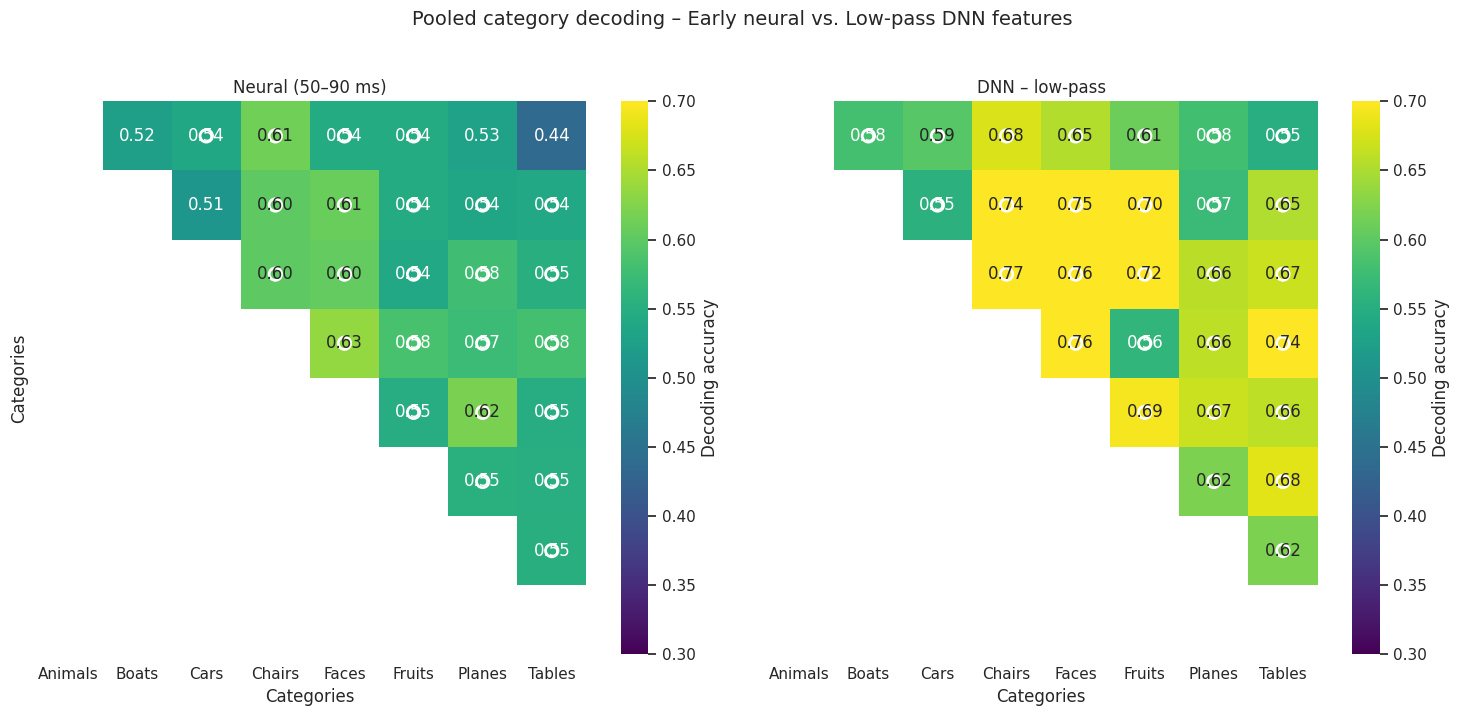

All done.


In [5]:
# ========================== Pairwise Category Decoding ========================
meta = pd.read_csv(meta_downloaded_path)
meta["base"] = meta["filename"].str.replace(r"\.\w+$", "", regex=True)
valid_idx = np.arange(640, len(meta))
meta = meta.iloc[valid_idx].reset_index(drop=True)

def flatten(data, t_idx):
    data = data[:, :, t_idx]
    data = data.reshape(data.shape[0], -1)
    return data

def decode_pair(cat1, cat2, X_flat, labels, obj_names):
    """
    Pairwise decoding with leave‑one‑object‑per‑category out.
    Aggregates per‑trial probabilities across all (o1,o0) test folds (no overwrite).
    """
    mask_pair  = (labels == cat1) | (labels == cat2)
    X_pair_all = X_flat[mask_pair]
    y_pair_all = (labels[mask_pair] == cat1).astype(int)
    obj_pair   = obj_names[mask_pair]

    # PCA fit scope

    train_mask_for_pca = (labels != cat1) & (labels != cat2)
    pca_global = PCA(n_components=50, random_state=42).fit(X_flat[train_mask_for_pca])

    n_pair = len(X_pair_all)
    sum_pos  = np.zeros(n_pair, dtype=float)
    sum_corr = np.zeros(n_pair, dtype=float)
    counts   = np.zeros(n_pair, dtype=int)

    objs1 = np.unique(obj_pair[y_pair_all == 1])
    objs0 = np.unique(obj_pair[y_pair_all == 0])

    clf = LogisticRegression(max_iter=500, solver="lbfgs", random_state=42)

    for o1 in objs1:
        for o0 in objs0:
            te_mask = (obj_pair == o1) | (obj_pair == o0)
            tr_mask = ~te_mask
            if tr_mask.sum() == 0 or te_mask.sum() == 0:
                continue


            X_tr = pca_global.transform(X_pair_all[tr_mask])
            X_te = pca_global.transform(X_pair_all[te_mask])

            y_tr = y_pair_all[tr_mask]
            y_te = y_pair_all[te_mask]

            clf.fit(X_tr, y_tr)
            proba_pos = clf.predict_proba(X_te)[:, 1]  # P(class==cat1)
            proba_corr = np.where(y_te == 1, proba_pos, 1 - proba_pos)

            idx_te_within_pair = np.flatnonzero(te_mask)
            sum_pos[idx_te_within_pair]  += proba_pos
            sum_corr[idx_te_within_pair] += proba_corr
            counts[idx_te_within_pair]   += 1

    valid = counts > 0
    if valid.sum() == 0:
        global_probs = np.full(len(labels), np.nan)
        global_probs[mask_pair] = np.nan
        return (cat1, cat2, np.nan, np.nan, global_probs)

    mean_pos  = np.full(n_pair, np.nan);  mean_pos[valid]  = sum_pos[valid] / counts[valid]
    mean_corr = np.full(n_pair, np.nan);  mean_corr[valid] = sum_corr[valid] / counts[valid]

    preds = (mean_pos[valid] >= 0.5).astype(int)
    acc   = (preds == y_pair_all[valid]).mean()
    k     = int(acc * valid.sum())
    pval  = binomtest(k, n=valid.sum(), p=0.5, alternative="greater").pvalue

    global_probs = np.full(len(labels), np.nan)
    global_probs[mask_pair] = mean_corr
    return (cat1, cat2, acc, pval, global_probs)

def parallel_decoding(X_flat, labels_cat, objects, cat_pairs):
    """Decode every category pair in parallel; return matrices and per-trial means."""
    results = Parallel(n_jobs=-1, backend="loky")(
        delayed(decode_pair)(c1, c2, X_flat, labels_cat, objects)
        for c1, c2 in cat_pairs
    )

    acc  = {(c1, c2): a for c1, c2, a, _, _ in results}
    pval = {(c1, c2): p for c1, c2, _, p, _ in results}
    probs= {(c1, c2): pr for c1, c2, _, _, pr in results}

    prob_matrix = np.stack([probs[pair] for pair in cat_pairs], axis=1)
    mean_trial  = np.nanmean(prob_matrix, axis=1)

    # FDR over all pairs
    p_vals = np.array([pval[pair] for pair in cat_pairs])
    _, q, _, _ = multipletests(p_vals, method="fdr_bh")
    qdict = {pair: qv for pair, qv in zip(cat_pairs, q)}

    categories = np.unique(labels_cat)
    nC = len(categories)
    A  = np.full((nC, nC), np.nan)
    S  = np.zeros((nC, nC), bool)
    for (c1, c2) in cat_pairs:
        i = np.where(categories == c1)[0][0]
        j = np.where(categories == c2)[0][0]
        if i < j:
            A[i, j] = acc[(c1, c2)]
            S[i, j] = qdict[(c1, c2)] < 0.05
    return A, S, probs, mean_trial

def plot_matrix(ax, M, Sig, title, categories, vmin=.3, vmax=.7):
    mask = np.isnan(M)
    sns.heatmap(M, vmin=vmin, vmax=vmax, cmap="viridis", mask=mask,
                annot=True, fmt=".2f",
                xticklabels=categories,
                yticklabels=categories if "Neural" in title else False,
                cbar_kws={"label": "Decoding accuracy"}, ax=ax)
    nC = len(categories)
    for i in range(nC):
        for j in range(nC):
            if i < j and Sig[i, j]:
                ax.scatter(j + .5, i + .5, s=80,
                           facecolors="none", edgecolors="white", linewidths=2)
    ax.set_title(title)
    ax.set_xlabel("Categories")
    if "Neural" in title:
        ax.set_ylabel("Categories")

# ------------------------------ Run pairwise decoding -------------------------
meta_df = meta.copy()
labels_cat = meta_df["category_name"].values
objects    = meta_df["object_name"].values
categories_unique = np.unique(labels_cat)
cat_pairs  = list(combinations(categories_unique, 2))

A_neu = S_neu = A_dnn = Sig_dnn = None

# Neural early features
if even_downloaded_path.exists() and odd_downloaded_path.exists():
    print("Pairwise category decoding — Neural (50–90 ms)…")
    rate_even = np.load(even_downloaded_path, allow_pickle=True)
    rate_odd  = np.load(odd_downloaded_path,  allow_pickle=True)
    even_raw, odd_raw = rate_even, rate_odd
    early_idx = slice(5, 9)  # 50–90 ms
    X_early = flatten((even_raw[valid_idx] + odd_raw[valid_idx]) / 2, early_idx)
    A_neu, S_neu, _, _ = parallel_decoding(X_early, labels_cat, objects, cat_pairs)
else:
    print("Skipping Neural pairwise decoding (missing spike files).")

# Low‑pass DNN features (pooled)
feature_dir = Path("deepNetFeatures")
if feature_dir.exists():
    print("Pairwise category decoding — Low‑pass DNN …")
    PKL_RE = re.compile(r"^(?P<net>.*?)_features_high_variation_lowpass\.pkl$")
    lowpass_pkls = [p for p in feature_dir.glob("*.pkl") if PKL_RE.match(p.name)]
    if not lowpass_pkls:
        print(f"No low‑pass DNN feature files found in {feature_dir}.")
    else:
        def process_net(pkl_path, meta_df):
            with open(pkl_path, "rb") as fh:
                feats = np.load(fh, allow_pickle=True)
            img_names = [PurePath(p).stem for p in feats["image_names"]]
            base = meta_df["filename"].str.replace(r"\.\w+$", "", regex=True)
            try:
                idx = np.array([img_names.index(b) for b in base])
            except ValueError:
                keep = [b in img_names for b in base]
                idx  = np.array([img_names.index(b) for b, k in zip(base, keep) if k])
            X = feats["penultimate"][idx]
            if X.ndim > 2:
                X = X.reshape(X.shape[0], -1)
            return X

        n_trials = len(labels_cat)
        sum_prob = np.zeros((n_trials, len(cat_pairs)), dtype=float)
        cnt_prob = np.zeros((n_trials, len(cat_pairs)), dtype=int)

        for pkl in lowpass_pkls:
            print(f"   · decoding {pkl.name}")
            X_net = process_net(pkl, meta_df)
            A_tmp, S_tmp, probs_net, _ = parallel_decoding(X_net, labels_cat, objects, cat_pairs)
            prob_matrix = np.stack([probs_net[pair] for pair in cat_pairs], axis=1)
            valid = ~np.isnan(prob_matrix)
            sum_prob[valid] += prob_matrix[valid]
            cnt_prob[valid] += 1

        mean_prob_dnn = np.where(cnt_prob > 0, sum_prob / cnt_prob, np.nan)
        np.save("Lowpass_probs.npy", mean_prob_dnn)
        np.save("mean_predprob_per_trial_lowpass.npy", np.nanmean(mean_prob_dnn, axis=1))

        # Build accuracy+significance matrices from pooled probs
        A_dnn = np.full((len(categories_unique), len(categories_unique)), np.nan)
        Sig_dnn = np.zeros_like(A_dnn, dtype=bool)
        pair_p = []
        for col, (c1, c2) in enumerate(cat_pairs):
            rows = np.where((labels_cat == c1) | (labels_cat == c2))[0]
            pvec = mean_prob_dnn[rows, col]
            ok   = ~np.isnan(pvec)
            n    = ok.sum()
            if n == 0:
                pair_p.append(1.0)
                continue
            k = int((pvec[ok] >= 0.5).sum())
            pair_p.append(binomtest(k, n=n, p=0.5, alternative="greater").pvalue)
            i = np.where(categories_unique == c1)[0][0]
            j = np.where(categories_unique == c2)[0][0]
            if i < j:
                A_dnn[i, j] = k / n

        _, qvals, _, _ = multipletests(pair_p, method="fdr_bh")
        for (c1, c2), qv in zip(cat_pairs, qvals):
            i = np.where(categories_unique == c1)[0][0]
            j = np.where(categories_unique == c2)[0][0]
            if i < j and qv < 0.05:
                Sig_dnn[i, j] = True
else:
    print("Skipping DNN pairwise decoding (deepNetFeatures folder not found).")

# ------------------------------ Plot: Category heatmaps -----------------------
if (A_neu is not None) or (A_dnn is not None):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

    if A_neu is not None:
        plot_matrix(axes[0], A_neu, S_neu, "Neural (50–90 ms)", categories_unique)
    else:
        axes[0].set_title("Neural (50–90 ms) - Data Missing")
        axes[0].set_xticks(range(len(categories_unique)))
        axes[0].set_xticklabels(categories_unique)
        axes[0].set_yticks(range(len(categories_unique)))
        axes[0].set_yticklabels(categories_unique)

    if A_dnn is not None:
        plot_matrix(axes[1], A_dnn, Sig_dnn, "DNN – low-pass", categories_unique)
    else:
        axes[1].set_title("DNN – low-pass - Data Missing")
        axes[1].set_xticks(range(len(categories_unique)))
        axes[1].set_xticklabels(categories_unique)

    fig.suptitle("Pooled category decoding – Early neural vs. Low‑pass DNN features",
                 y=1.02, fontsize=14)
    plt.tight_layout()
    out_svg = FIG_DIR / "combined_decoding.svg"
    out_png = FIG_DIR / "combined_decoding.png"
    out_pdf = FIG_DIR / "combined_decoding.pdf"
    fig.savefig(out_svg); fig.savefig(out_png, dpi=300); fig.savefig(out_pdf)
    print(f"Category figures saved → {out_png}\n                         {out_svg}\n                         {out_pdf}")
    plt.show()

print("All done.")

# Distance to object prototype

## Analysis

Loading metadata …
Loading neural data …
Running PCA …
Figure saved to Figures/gain_rotated_density.(png|svg)


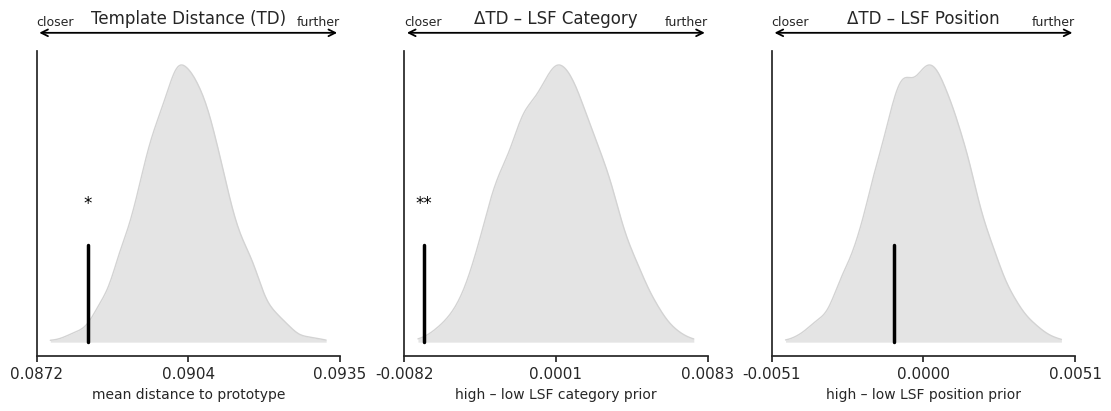

In [6]:
META_PATH      = 'downloads/hvm_public_extended_meta.csv'
EVEN_PATH      = 'downloads/Spike_count_even_sessions.npy'
ODD_PATH       = 'downloads/Spike_count_odd_sessions.npy'
CAT_PROB_PATH  = 'mean_predprob_per_trial_lowpass.npy'
POS_ERR_PATH   = 'mean_pos_error_per_trial.npy'

FIG_DIR        = 'Figures'
STAT_DIR       = 'Statistics'
N_PERM         = 10_000   # permutations / sign‑flips
RNG_SEED       = 42

PALETTE = {'Perm': 'lightgray', 'Obs': 'black'}
plt.rcParams.update({"svg.fonttype": "none"})  # editable text in SVG

# Create Statistics directory if it doesn't exist
os.makedirs(STAT_DIR, exist_ok=True)

# ───────────────────────────── helper functions ──────────────────────────────
@jit
def sqeucl(mat: jnp.ndarray, vec: jnp.ndarray) -> jnp.ndarray:
    """Row‑wise mean‑squared Euclidean distance to *vec*."""
    return jnp.mean((mat - vec) ** 2, axis=1)

def q_to_stars(q: float) -> str:
    if q < 1e-4: return '****'
    if q < 1e-3: return '***'
    if q < 1e-2: return '**'
    if q < 5e-2: return '*'
    return ''

def _set_three_ticks(ax):
    """Force exactly three evenly‑spaced xticks on current x‑limits."""
    xmin, xmax = ax.get_xlim()
    ticks = np.linspace(xmin, xmax, 3)
    ax.set_xticks(ticks)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))


def plot_rotated_density_single(ax, title, obs, null_dist, p_val, xlabel):
    """One rotated‑density panel (with three xticks)."""
    # KDE grid on 0.1–99.9 % range
    p_lo, p_hi = np.percentile(null_dist, [0.1, 99.9])
    pad = 0.02 * (p_hi - p_lo)
    x_g = np.linspace(p_lo - pad, p_hi + pad, 200)
    dens = gaussian_kde(null_dist)(x_g)
    dens[dens < 0.005 * dens.max()] = 0
    max_d = dens.max() or 1e-8

    # density + observed line
    ax.fill_between(x_g, 0, dens, color=PALETTE['Perm'], alpha=.6, lw=0)
    ax.plot(x_g, dens, color=PALETTE['Perm'], lw=1)
    ln = 0.35 * max_d
    ax.plot([obs, obs], [0, ln], color=PALETTE['Obs'], lw=2.5)

    # stars
    if (stars := q_to_stars(p_val)):
        ax.text(obs, ln + 0.12 * max_d, stars, ha='center', va='bottom',
                fontsize=12, color=PALETTE['Obs'])

    # cosmetics
    ax.set_yticks([])
    ax.tick_params(axis='y', left=False, labelleft=False)
    for s in ax.spines.values():
        s.set_visible(False)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.tick_params(axis='x', bottom=True, labelbottom=True, length=4)
    ax.set_title(title, fontsize=12, pad=20)

    # enforce three ticks after limits settle
    _set_three_ticks(ax)

    # arrow
    arrow_y = 1.06
    ax.annotate('', xy=(1, arrow_y), xytext=(0, arrow_y),
                xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(arrowstyle='<->', lw=1.3, color='black'),
                clip_on=False)
    ax.text(0, arrow_y + 0.015, 'closer', transform=ax.transAxes,
            ha='left', va='bottom', fontsize=9)
    ax.text(1, arrow_y + 0.015, 'further', transform=ax.transAxes,
            ha='right', va='bottom', fontsize=9)


# ‑‑‑ metadata
print('Loading metadata …')
meta = pd.read_csv(META_PATH)
low_var = meta.variation == 0
high_var = meta.variation == 3
high_idx = np.nonzero(high_var.values)[0]
g2h = -np.ones(len(meta), int); g2h[high_idx] = np.arange(high_idx.size)

# ‑‑‑ neural data (100–200 ms)
print('Loading neural data …')
rate = (np.load(EVEN_PATH) + np.load(ODD_PATH)) / 2.0
late_bins = np.where((np.arange(0, 200, 10) > 100) & (np.arange(0, 200, 10) <= 200))[0]
X = rate[:, :, late_bins].reshape(rate.shape[0], -1).astype('float32')
X = jnp.array(X)

# ‑‑‑ PCA
print('Running PCA …')
Xc = X - X.mean(axis=0)
_, _, Vt = jnp.linalg.svd(Xc, full_matrices=False)
comps = Vt[:50]

proj_high = (X[high_idx] - X.mean(axis=0)) @ comps.T
hv_obj = meta.object_name.values[high_idx]
hv_cat = meta.category_name.values[high_idx]

cat_prob = np.load(CAT_PROB_PATH)
pos_err  = np.load(POS_ERR_PATH)

rng = np.random.default_rng(RNG_SEED)
dist_true, dist_nulls = [], []
gain_cat, gain_pos = [], []
pvals = [] # Store p-values for FDR correction

for obj in meta.object_name.unique():
    lv_idx = meta[(meta.object_name == obj) & low_var].index.values
    hv_idx = meta[(meta.object_name == obj) & high_var].index.values
    if lv_idx.size == 0 or hv_idx.size == 0:
        continue
    template = (X[lv_idx] - X.mean(axis=0)) @ comps.T
    template = template.mean(axis=0)

    hv_hi = g2h[hv_idx]
    dists = np.asarray(sqeucl(proj_high[hv_hi], template))
    dist_true.append(dists.mean())

    cat = meta.category_name[lv_idx[0]]
    pool = proj_high[(hv_cat == cat) & (hv_obj != obj)]
    pool_d = np.asarray(sqeucl(pool, template))
    if pool_d.size == 0:
        continue
    perm_means = rng.choice(pool_d, size=(N_PERM, hv_idx.size), replace=True).mean(axis=1)
    dist_nulls.append(perm_means)
    pvals.append((perm_means <= dists.mean()).mean()) # Store p-value

    # gains
    cp, pe = cat_prob[hv_hi], pos_err[hv_hi]
    mask_exp = cp > np.median(cp);  mask_un = ~mask_exp
    mask_loc = pe < np.median(pe);  mask_mis = ~mask_loc
    if mask_exp.any() and mask_un.any() and mask_loc.any() and mask_mis.any():
        gain_cat.append(dists[mask_exp].mean() - dists[mask_un].mean())
        gain_pos.append(dists[mask_loc].mean() - dists[mask_mis].mean())

# ‑‑‑ stats
dist_true = np.array(dist_true)
dist_nulls = np.vstack(dist_nulls)
emp_dist = dist_true.mean()
null_dist = dist_nulls.mean(axis=0)  # <‑‑ axis=0 : distribution of grand mean
# Apply FDR correction to the p-values from the loop
_, q_dist_corrected, _, _ = multipletests(pvals, method='fdr_bh')
p_dist = (null_dist <= emp_dist).mean() # This is the p-value for the grand mean, not the individual objects

emp_cat, emp_pos = np.mean(gain_cat), np.mean(gain_pos)
signs = rng.choice([-1, 1], size=(N_PERM, len(gain_cat)))
null_cat = (np.array(gain_cat)[None, :] * signs).mean(axis=1)
null_pos = (np.array(gain_pos)[None, :] * signs).mean(axis=1)
p_cat = (null_cat <= emp_cat).mean(); p_pos = (null_pos <= emp_pos).mean()

# Save q-values to Statistics folder
np.save(os.path.join(STAT_DIR, 'q_values_template_distance.npy'), q_dist_corrected)
np.save(os.path.join(STAT_DIR, 'p_value_mean_distance.npy'), p_dist) # Save grand mean p-value
np.save(os.path.join(STAT_DIR, 'p_value_gain_cat.npy'), p_cat)
np.save(os.path.join(STAT_DIR, 'p_value_gain_pos.npy'), p_pos)


# ‑‑‑ plotting
fig, axes = plt.subplots(1, 3, figsize=(11, 4), constrained_layout=True)
plot_rotated_density_single(axes[0], 'Template Distance (TD)',
                            emp_dist, null_dist, p_dist, # Using the grand mean p-value for the plot
                            'mean distance to prototype')
plot_rotated_density_single(axes[1], 'ΔTD – LSF Category',
                            emp_cat, null_cat, p_cat,
                            'high – low LSF category prior')
plot_rotated_density_single(axes[2], 'ΔTD – LSF Position',
                            emp_pos, null_pos, p_pos,
                            'high – low LSF position prior')
sns.despine()

os.makedirs(FIG_DIR, exist_ok=True)
for ext in ('png', 'svg','pdf'):
    fig.savefig(os.path.join(FIG_DIR, f'gain_rotated_density.{ext}'), dpi=300)
print(f'Figure saved to {FIG_DIR}/gain_rotated_density.(png|svg)')

## Illustrations of hypothesis

### Distance to template

Figure saved to Figures/schema_images_generated.jpeg


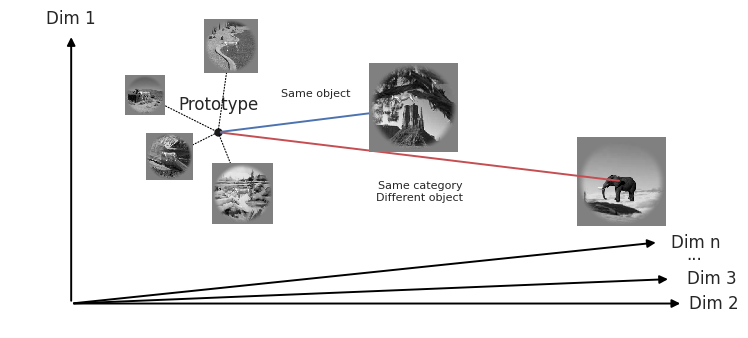

In [7]:
CATEGORY        = "animal"      # one of meta.category_name
OBJ_MAIN        = "lioness"      # object shown in LOW + HIGH-same-object
OBJ_OTHER       = "elephant"       # another object from the same category

# 2-D coordinates (Dim-1 vs Dim-50 plane, arbitrary units)
PROTOTYPE_PT    = (1.2, 1.4)
LOW_COORDS      = [
    (0.6, 1.70),
    (1.3, 2.1),
    (0.8, 1.20),
    (1.4, .9),
]
HIGH_SAME_COORD = (2.8, 1.60)
HIGH_DIFF_COORD = (4.5, 1)

# Relative image size
LOW_ZOOMS        = (0.11,.15,0.13,0.17)
HIGH_ZOOMS       = (.25,0.25)

# Data file names (change if yours differ)
META_CSV        = "downloads/hvm_public_extended_meta.csv"
ZIP_LOW         = "downloads/background_variations_images.zip"
ZIP_HIGH        = "downloads/high_variation_stimuli.zip"
OUT_FIG         = "Figures/schema_images_generated.jpeg"
# ======================================================================

import io, random, zipfile, os, sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import FancyBboxPatch
from PIL import Image
import numpy as np
np.random.seed(42)
# ---------- Helper: load PNG by SHA-1 inside a zip (search subfolders) --
def load_image_from_zip(zfile: zipfile.ZipFile, sha_png: str):
    for name in zfile.namelist():
        if name.endswith(sha_png):
            with zfile.open(name) as f:
                return Image.open(io.BytesIO(f.read()))
    return None

# ---------- Load metadata & archives -----------------------------------
if not os.path.exists(META_CSV):
    sys.exit(f"Metadata file '{META_CSV}' not found.")
meta = pd.read_csv(META_CSV)

try:
    zip_low  = zipfile.ZipFile(ZIP_LOW)
    zip_high = zipfile.ZipFile(ZIP_HIGH)
except FileNotFoundError as e:
    sys.exit(e)

# Helper to embed image
def add_image(img, xy, zoom):
    if img is None:
        rect = FancyBboxPatch((xy[0]-0.14, xy[1]-0.14), 0.28, 0.28,
                              boxstyle="round,pad=0.02", edgecolor='red', facecolor='white')
        ax.add_patch(rect)
        ax.text(*xy, "MISSING", ha='center', va='center', fontsize=6)
        return
    ab = AnnotationBbox(OffsetImage(img, zoom=zoom), xy, frameon=False, pad=0)
    ax.add_artist(ab)
# ---------- Pick exemplar filenames ------------------------------------
def pick_images(obj_name, variation, k):
    rows = meta[(meta.object_name == obj_name) & (meta.variation == variation)]
    if len(rows) < k:
        sys.exit(f"Not enough images for '{obj_name}', variation {variation}")
    return random.sample(rows["filename"].tolist(), k)

sha_low  = pick_images(OBJ_MAIN, 0, 4)       # four low-variation
sha_same = pick_images(OBJ_MAIN, 3, 1)[0]    # same object, high-variation
sha_diff = pick_images(OBJ_OTHER, 3, 1)[0]   # diff object, high-variation

# ---------- Load PIL images --------------------------------------------
def get_img(sha1):
    return (load_image_from_zip(zip_low,  sha1)
            or load_image_from_zip(zip_high, sha1))

img_low   = [get_img(s) for s in sha_low]
img_same  = get_img(sha_same)
img_diff  = get_img(sha_diff)

# ---------- Build figure -----------------------------------------------
fig, ax = plt.subplots(figsize=(9, 5))
ax.set_aspect('equal')
ax.set_xlim(-0.5, 5.2)
ax.set_ylim(-0.2, 2.4)
ax.axis('off')

# Axes arrows

ax.annotate("", xy=(0.0, 2.2), xytext=(0, 0),
            arrowprops=dict(arrowstyle='-|>', lw=1.4, color='black'))
ax.text(0, 2.25, "Dim 1", va='bottom', ha='center')

ax.annotate("", xy=(5.0, 0.0), xytext=(0, 0),
            arrowprops=dict(arrowstyle='-|>', lw=1.4, color='black'))
ax.text(5.05, 0, "Dim 2", va='center', ha='left')

ax.annotate("", xy=(4.9, .2), xytext=(0, 0),
            arrowprops=dict(arrowstyle='-|>', lw=1.4, color='black'))
ax.text(5.03, .2, "Dim 3", va='center', ha='left')

ax.text(5.03, .4, "...", va='center', ha='left')

ax.annotate("", xy=(4.8, .5), xytext=(0, 0),
            arrowprops=dict(arrowstyle='-|>', lw=1.4, color='black'))
ax.text(4.9, .5, "Dim n", va='center', ha='left')


# High-variation different object

mid_diff = ((PROTOTYPE_PT[0]+HIGH_DIFF_COORD[0])/2,
            (PROTOTYPE_PT[1]+HIGH_DIFF_COORD[1])/2)
add_image(img_diff, HIGH_DIFF_COORD, HIGH_ZOOMS[1])
ax.annotate("", xy=HIGH_DIFF_COORD, xytext=PROTOTYPE_PT,
            arrowprops=dict(arrowstyle='-', lw=1.4,color = 'r'))

# Prototype
ax.plot(*PROTOTYPE_PT, 'ko', markersize=5)
ax.text(PROTOTYPE_PT[0], PROTOTYPE_PT[1] + 0.15, "Prototype",
        ha='center', va='bottom')


# Low-variation images (dotted connectors)
for coord, img,LOW_ZOOM in zip(LOW_COORDS, img_low,LOW_ZOOMS):
    ax.annotate("", xy=PROTOTYPE_PT, xytext=coord,
                arrowprops=dict(lw=0.8, linestyle='dotted',
                                arrowstyle='-', color='black'))
    add_image(img, coord, LOW_ZOOM)


# High-variation same object
ax.annotate("", xy=HIGH_SAME_COORD, xytext=PROTOTYPE_PT,
            arrowprops=dict(arrowstyle='-', lw=1.4,color = 'b'))
mid_same = ((PROTOTYPE_PT[0]+HIGH_SAME_COORD[0])/2,
            (PROTOTYPE_PT[1]+HIGH_SAME_COORD[1])/2)

add_image(img_same, HIGH_SAME_COORD, HIGH_ZOOMS[0])

ax.text(mid_same[0], mid_same[1]+0.17, "Same object",
        ha='center', va='bottom', fontsize=8)



ax.text(mid_diff[0], mid_diff[1]-0.20,
        "Same category\nDifferent object", ha='center', va='top', fontsize=8)

# ---------- Save --------------------------------------------------------
fig.savefig(OUT_FIG, dpi=600, bbox_inches='tight')
print("Figure saved to", OUT_FIG)

### Example LSF predictors

Saved figure: Figures/extreme_gallery.png


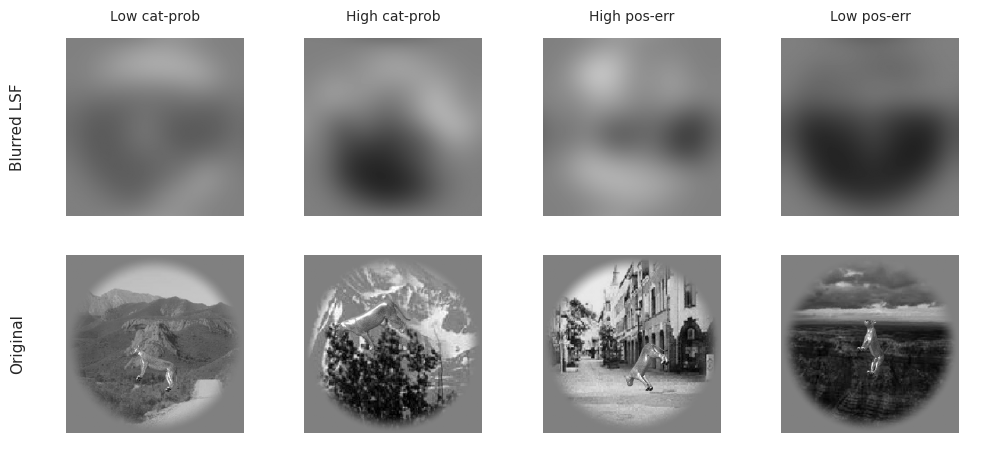

In [8]:
OBJECT        = "lioness"          # any object in the metadata
VARIATION     = 3              # use high‑variation exemplars
FOV_DEG       = 8.0            # field‑of‑view for Gaussian filter
ZOOM          = 0.5           # image zoom in subplot
OUT_FIG       = "Figures/extreme_gallery.png"
# paths (adjust if needed)
META_CSV      = "downloads/hvm_public_extended_meta.csv"
ZIP_LOW       = "downloads/background_variations_images.zip"
ZIP_HIGH      = "downloads/high_variation_stimuli.zip"
PRED_CAT_NPY  = "mean_predprob_per_trial_lowpass.npy"
PRED_POS_NPY  = "mean_pos_error_per_trial.npy"
# ═══════════════════════════════════════════════════════════

import io, zipfile, sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

# ------------------------------------------------------------------
# 1  Import the magnocellular low‑pass filter (identical to Script 2)
# ------------------------------------------------------------------
try:
    from utils.image_processing import m_pathway_filter_gaussian
except ModuleNotFoundError:
    import numpy as _np

    def m_pathway_filter_gaussian(image, cutoff_cpd: float = 0.5,
                                  fov_deg: float = 8.0,
                                  atten_dB_at_cut: float = -20):
        """Legacy fallback Gaussian low‑pass filter."""
        cutoff_cycles = cutoff_cpd * fov_deg
        gain          = 10 ** (atten_dB_at_cut / 20)
        sigma         = cutoff_cycles / _np.sqrt(-2 * _np.log(gain))
        F             = _np.fft.fft2(image)
        r, c          = image.shape
        rf, cf        = _np.fft.fftfreq(r) * r, _np.fft.fftfreq(c) * c
        U, V          = _np.meshgrid(cf, rf)
        H             = _np.exp(-(U ** 2 + V ** 2) / (2 * sigma ** 2))
        return _np.fft.ifft2(F * H).real

# ---------- 2  Load metadata & predictors --------------------------
meta       = pd.read_csv(META_CSV)
cat_pred   = np.load(PRED_CAT_NPY)   # higher = more expected
pos_err    = np.load(PRED_POS_NPY)   # lower  = better localisation

# ---------- 3  Restrict to chosen object & variation ---------------
meta_high  = meta[meta.variation == VARIATION].reset_index(drop=True)
sel        = meta_high[meta_high.object_name == OBJECT]
if len(sel) < 10:
    sys.exit("Not enough images for that selection.")

idx = sel.index.to_numpy()

# ---------- 4  Pick extremes ---------------------------------------
idx_of_extreme = lambda arr, k, largest=True: arr.argsort()[-k:] if largest else arr.argsort()[:k]

lo_cat_idx = idx_of_extreme(cat_pred[idx], 1, largest=False)[0]
hi_cat_idx = idx_of_extreme(cat_pred[idx], 1, largest=True )[0]
hi_pos_idx = idx_of_extreme(pos_err [idx], 1, largest=True )[0]
lo_pos_idx = idx_of_extreme(pos_err [idx], 1, largest=False)[0]

selected_global = idx[[lo_cat_idx, hi_cat_idx, hi_pos_idx, lo_pos_idx]]
labels = ["Low cat‑prob", "High cat‑prob",
          "High pos‑err", "Low pos‑err"]

# ---------- 5  Helper – load PNG from zips -------------------------
zip_low  = zipfile.ZipFile(ZIP_LOW)
zip_high = zipfile.ZipFile(ZIP_HIGH)

def load_sha1(sha: str):
    """Locate image with the given SHA‑1 name in either ZIP archive."""
    for z in (zip_low, zip_high):
        for n in z.namelist():
            if n.endswith(sha):
                return Image.open(io.BytesIO(z.read(n))).convert("L")
    return None

sha_names = meta_high.loc[selected_global, "filename"].tolist()
images    = [load_sha1(s) for s in sha_names]

# ---------- 6  Apply magnocellular low‑pass ------------------------
blurred = []
for im in images:
    if im is None:
        blurred.append(None); continue
    lp = m_pathway_filter_gaussian(np.asarray(im), fov_deg=FOV_DEG)
    if lp.dtype != np.uint8:
        lp = np.clip(lp, 0, 255).astype("uint8")  # absolute range, no rescale
    blurred.append(lp)

# ---------- 7  Plot -------------------------------------------------
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
abs_norm = mcolors.Normalize(vmin=0, vmax=255)  # fixed grey mapping

for col, (orig, blur, lab) in enumerate(zip(images, blurred, labels)):
    for row in (0, 1):
        ax = axes[row, col]
        ax.axis("off")
        arr = blur if row == 0 else orig
        if arr is None:
            ax.text(0.5, 0.5, "MISSING", ha="center", va="center", fontsize=8)
            continue
        if isinstance(arr, Image.Image):
            arr = np.asarray(arr)
        box = OffsetImage(arr, zoom=ZOOM, cmap="gray", norm=abs_norm)
        ab  = AnnotationBbox(box, (0.5, 0.5), frameon=False, pad=0)
        ax.add_artist(ab)
    axes[0, col].set_title(lab, fontsize=10)

axes[0, 0].text(-0.15, 0.5, "Blurred LSF", rotation=90,
                ha="center", va="center", fontsize=11, transform=axes[0, 0].transAxes)
axes[1, 0].text(-0.15, 0.5, "Original",    rotation=90,
                ha="center", va="center", fontsize=11, transform=axes[1, 0].transAxes)


fig.tight_layout(rect=[0, 0, 1, 0.94])
fig.savefig(OUT_FIG, dpi=600)
print("Saved figure:", OUT_FIG)


# Download figures and statistics

In [9]:
import os
from google.colab import files

# Define the directories to zip
directories_to_zip = ["Figures", "Statistics"]
zip_filename = "results_LSF_top_down.zip"

# Check if directories exist before zipping
existing_directories = [d for d in directories_to_zip if os.path.exists(d)]

if existing_directories:
    # Create a zip archive of the specified directories
    zip_command = f"zip -r {zip_filename} {' '.join(existing_directories)}"
    os.system(zip_command)

    # Provide a download link for the zip file
    if os.path.exists(zip_filename):
        print(f"Created {zip_filename}. You can download it using the link below.")
        files.download(zip_filename)
    else:
        print(f"Failed to create {zip_filename}.")
else:
    print("Neither the 'Figures' nor the 'Statistics' directory was found.")

Created results_LSF_top_down.zip. You can download it using the link below.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>